In [176]:
import tfim
import tfim_perturbation
import tfim_matrices
import numpy as np
from scipy import sparse
from scipy.sparse import linalg as spla
from scipy import linalg
import matplotlib.pyplot as plt
from scipy import optimize
import progressbar
import itertools

In [177]:
# For plotting 

marker = itertools.cycle((',', '+', '.', '1','2','3','4','|')) 

In [178]:
# Initial system specification
L = [5]
Jij_seed = 19
h_x_range = np.logspace(-4, -2, 40)

In [179]:
PBC = True
J = 1

In [180]:
# Build lattice and basis
###################################
lattice = tfim.Lattice(L, PBC)
N = lattice.N
basis = tfim.IsingBasis(lattice)
###################################

In [181]:
#construct random J matrix
Jij = tfim.Jij_instance(N,J,"bimodal",Jij_seed) 

In [182]:
# List out all the spin_states, corresponding indices and energies
Energies = -tfim.JZZ_SK_ME(basis,Jij)
for index in range(2**N):
    print(index, basis.state(index), Energies[index])

100% (32 of 32) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


0 [0 0 0 0 0] -0.0
1 [0 0 0 0 1] -4.0
2 [0 0 0 1 0] 4.0
3 [0 0 0 1 1] -4.0
4 [0 0 1 0 0] -4.0
5 [0 0 1 0 1] -4.0
6 [0 0 1 1 0] 4.0
7 [0 0 1 1 1] -0.0
8 [0 1 0 0 0] 4.0
9 [0 1 0 0 1] 4.0
10 [0 1 0 1 0] 4.0
11 [0 1 0 1 1] -0.0
12 [0 1 1 0 0] -4.0
13 [0 1 1 0 1] -0.0
14 [0 1 1 1 0] -0.0
15 [0 1 1 1 1] -0.0
16 [1 0 0 0 0] -0.0
17 [1 0 0 0 1] -0.0
18 [1 0 0 1 0] -0.0
19 [1 0 0 1 1] -4.0
20 [1 0 1 0 0] -0.0
21 [1 0 1 0 1] 4.0
22 [1 0 1 1 0] 4.0
23 [1 0 1 1 1] 4.0
24 [1 1 0 0 0] -0.0
25 [1 1 0 0 1] 4.0
26 [1 1 0 1 0] -4.0
27 [1 1 0 1 1] -4.0
28 [1 1 1 0 0] -4.0
29 [1 1 1 0 1] 4.0
30 [1 1 1 1 0] -4.0
31 [1 1 1 1 1] -0.0


In [183]:
# Build a list of excited state indices that are one Hamming distances away from ground states
GS_energy, GS_indices = tfim_perturbation.GS(Energies)

In [184]:
# Build exact matrix
V_exc = tfim_perturbation.V_exact(basis, lattice)

H_0_exc = tfim_perturbation.H_0_exact(Energies)

In [185]:
# Calculate approximated eigenvalues and eigenstates for range(h_x)
app_eigenvalues_2, app_eigenstates_2 = tfim_perturbation.app_2_eigensystem_general_matrices(GS_indices, GS_energy, h_x_range, J, N, basis, Jij)
app_eigenvalues_3, app_eigenstates_3 = tfim_perturbation.app_3_eigensystem_general_matrices(GS_indices, GS_energy, h_x_range, J, N, basis, Jij)
app_eigenvalues_4, app_eigenstates_4 = tfim_perturbation.app_4_eigensystem_general_matrices(GS_indices, GS_energy, h_x_range, J, N, basis, Jij)

print(np.shape(app_eigenvalues_4))

(10, 40)


In [186]:
# Calculate exact eigenvalues and eigenstates for range(h_x)
exc_eigenvalues, exc_eigenstates = tfim_perturbation.exc_eigensystem(basis, h_x_range, lattice, Energies)

In [187]:
# Extract exact ground states
exc_GS_eigenstates = np.zeros((len(h_x_range), len(GS_indices), len(GS_indices)))

for i in range(len(h_x_range)):
    for m, j in enumerate(GS_indices):
        for n, k in enumerate(GS_indices):
            exc_GS_eigenstates[i, m, n] = exc_eigenstates[i, j, n]

In [188]:
# Extract exact ground energy

In [189]:
reordered_app_eigenstates = np.zeros([len(h_x_range), len(GS_indices), len(GS_indices)])
epsilon = 1*10**(-6)

for h_x_index in range(len(h_x_range)):
    if h_x_index < 2:
        reordered_app_eigenstates[h_x_index] = app_eigenstates_4[h_x_index]
    else: 
        for k in range(len(GS_indices)//2):
            fidelity_array = []
            for v1 in [reordered_app_eigenstates[h_x_index-1, :, 2*k], reordered_app_eigenstates[h_x_index-1, :, 2*k+1]]:
                for v2 in [app_eigenstates_4[h_x_index, :, 2*k], app_eigenstates_4[h_x_index, :, 2*k+1]]:
                    fidelity_array = np.append(fidelity_array,tfim_perturbation.fidelity(v1,v2))
            if abs(fidelity_array[0] - max(fidelity_array)) < epsilon:
                reordered_app_eigenstates[h_x_index, :, 2*k] = app_eigenstates_4[h_x_index, :, 2*k]
                reordered_app_eigenstates[h_x_index, :, 2*k + 1] = app_eigenstates_4[h_x_index, :, 2*k + 1]
            else:
                reordered_app_eigenstates[h_x_index, :, 2*k] = app_eigenstates_4[h_x_index, :, 2*k + 1]
                reordered_app_eigenstates[h_x_index, :, 2*k + 1] = app_eigenstates_4[h_x_index, :, 2*k]

In [190]:
reordered_exc_GS_eigenstates = np.zeros([len(h_x_range), len(GS_indices), len(GS_indices)])
epsilon = 1*10**(-12)

for h_x_index in range(len(h_x_range)):
    if h_x_index < 2:
        reordered_exc_GS_eigenstates[h_x_index] = exc_GS_eigenstates[h_x_index]
    else: 
        for k in range(len(GS_indices)//2):
            fidelity_array = []
            for v1 in [reordered_exc_GS_eigenstates[h_x_index-1, :, 2*k], reordered_exc_GS_eigenstates[h_x_index-1, :, 2*k+1]]:
                for v2 in [exc_GS_eigenstates[h_x_index, :, 2*k], exc_GS_eigenstates[h_x_index, :, 2*k+1]]:
                    fidelity_array = np.append(fidelity_array,tfim_perturbation.fidelity(v1,v2))
            if abs(fidelity_array[0] - max(fidelity_array)) < epsilon:
                reordered_exc_GS_eigenstates[h_x_index, :, 2*k] = exc_GS_eigenstates[h_x_index, :, 2*k]
                reordered_exc_GS_eigenstates[h_x_index, :, 2*k + 1] = exc_GS_eigenstates[h_x_index, :, 2*k + 1]
            else:
                reordered_exc_GS_eigenstates[h_x_index, :, 2*k] = exc_GS_eigenstates[h_x_index, :, 2*k + 1]
                reordered_exc_GS_eigenstates[h_x_index, :, 2*k + 1] = exc_GS_eigenstates[h_x_index, :, 2*k]

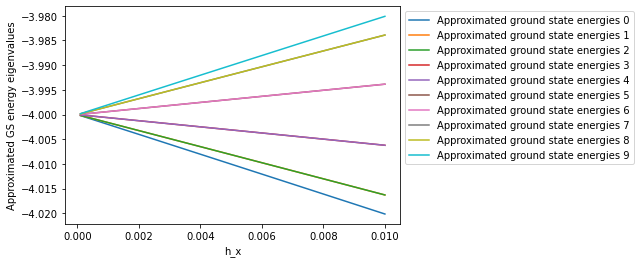

In [191]:
# Plot app GS energy vs h_x
for i in range(len(GS_indices)):
    app_GS_energy_plot = plt.plot(h_x_range, app_eigenvalues_4[i],label = 'Approximated ground state energies ' + str(i))
    plt.legend(loc = 'best', bbox_to_anchor=(1, 1), ncol = 1)
plt.ylabel("Approximated GS energy eigenvalues")
plt.xlabel("h_x")
plt.show(app_GS_energy_plot)

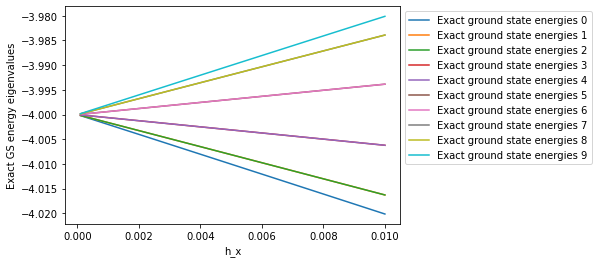

In [192]:
# Plot exc GS energy vs h_x
for i in range(len(GS_indices)):
    exc_GS_energy_plot = plt.plot(h_x_range, exc_eigenvalues[i], label = 'Exact ground state energies ' + str(i))
    plt.legend(loc = 'best', bbox_to_anchor=(1, 1), ncol = 1)
plt.ylabel("Exact GS energy eigenvalues")
plt.xlabel("h_x")
plt.show(exc_GS_energy_plot)

Text(0.5, 0, 'h_x')

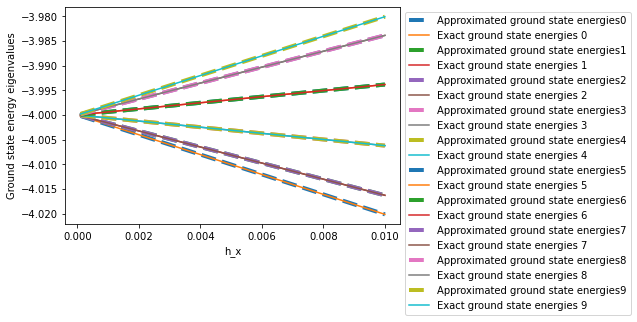

In [193]:
# Compare the exact and approximated GS energies

for i in range(len(GS_indices)):
    plt.plot(h_x_range, app_eigenvalues_4[i], '--', linewidth = 4, label = 'Approximated ground state energies' + str(i))
    plt.plot(h_x_range, exc_eigenvalues[i],label = 'Exact ground state energies ' + str(i))
    plt.legend(loc = 'best', bbox_to_anchor=(1, 1), ncol = 1)
plt.ylabel("Ground state energy eigenvalues")
plt.xlabel("h_x")

Text(0, 0.5, 'Ground state energy error')

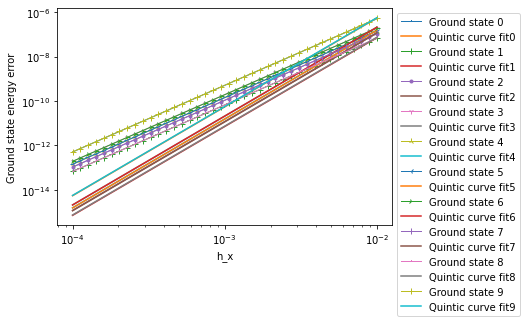

In [194]:
# Calculate and plot energy errors

corrected_exc_eigenvalues = np.zeros((len(GS_indices), len(h_x_range)))

for i in range(len(GS_indices)):
    for j in range(len(h_x_range)):
        corrected_exc_eigenvalues[i, j] = exc_eigenvalues[i, j]

error_array_4 = np.absolute(corrected_exc_eigenvalues - app_eigenvalues_4)
error_array_3 = np.absolute(corrected_exc_eigenvalues - app_eigenvalues_3)
error_array_2 = np.absolute(corrected_exc_eigenvalues - app_eigenvalues_2)

# Curve fit

for i in range(len(GS_indices)):
    popt, pcov = optimize.curve_fit(tfim_perturbation.poly_4, h_x_range, error_array_4[i])
    GS_energy_error_plot = plt.plot(h_x_range, error_array_4[i], marker = next(marker), linewidth = 1, label = 'Ground state ' + str(i))
    plt.plot(h_x_range, tfim_perturbation.poly_4(h_x_range, *popt), label = 'Quintic curve fit' + str(i))
    plt.legend(loc = 'best', bbox_to_anchor=(1, 1), ncol = 1)
    plt.xscale('log')
    plt.yscale('log')
plt.xlabel('h_x')
plt.ylabel('Ground state energy error')

[0.0610129  2.98483463]
[0.58448629 3.00072166]
[0.2396851  3.00176865]


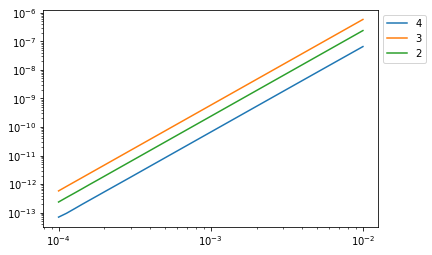

In [195]:
def powerlaw(x, A, b):
    return A*x**b

error_array_4 = np.absolute(corrected_exc_eigenvalues - app_eigenvalues_4)
error_array_3 = np.absolute(corrected_exc_eigenvalues - app_eigenvalues_3)
error_array_2 = np.absolute(corrected_exc_eigenvalues - app_eigenvalues_2)

state = 1

plt.plot(h_x_range, error_array_4[state], label = '4')
popt_4, pcov_4 = optimize.curve_fit(powerlaw, h_x_range, error_array_4[state])
print(popt_4)
plt.plot(h_x_range, error_array_3[state], label = '3')
popt_3, pcov_3 = optimize.curve_fit(powerlaw, h_x_range, error_array_3[state])
print(popt_3)
plt.plot(h_x_range, error_array_2[state], label = '2')
popt_2, pcov_2 = optimize.curve_fit(powerlaw, h_x_range, error_array_2[state])
print(popt_2)
plt.legend(loc = 'best', bbox_to_anchor=(1, 1), ncol = 1)
plt.xscale('log')
plt.yscale('log')

In [196]:
print(np.finfo(float).eps)

2.220446049250313e-16


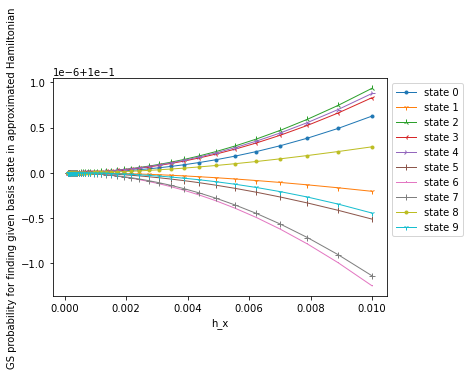

In [197]:
# Calculate probabilities for approximated eigenstates

prob_app = tfim_perturbation.prob_app(GS_indices, h_x_range, reordered_app_eigenstates)

# Plot probabilities for finding six bases states for system in ground eigenstate (approximated)

for i in range(len(GS_indices)):
    app_GS_probability_plot = plt.plot(h_x_range, prob_app[i], marker = next(marker), linewidth = 1, label = 'state ' + str(i))
    plt.legend(loc = 'best', bbox_to_anchor=(1, 1), ncol = 1)
plt.ylabel("GS probability for finding given basis state in approximated Hamiltonian")
plt.xlabel('h_x')
plt.show(app_GS_probability_plot)

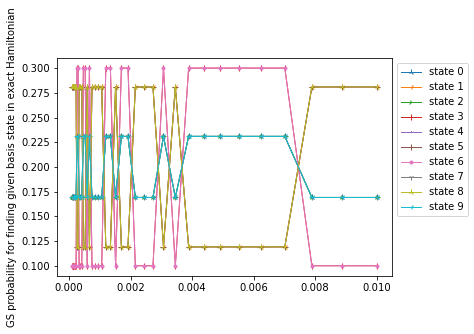

In [198]:
# Calculate probabilities for exact eigenstates

prob_exc_0 = tfim_perturbation.prob_exc(GS_indices, h_x_range, reordered_exc_GS_eigenstates, 0)
prob_exc_1 = tfim_perturbation.prob_exc(GS_indices, h_x_range, reordered_exc_GS_eigenstates, 1)

# Plot probabilities for finding six bases states for system in ground eigenstate (exact)

prob_exc = prob_exc_0 + prob_exc_1

for i in range(len(GS_indices)):
    plt.plot(h_x_range, prob_exc[i], marker = next(marker), linewidth = 1, label = 'state ' + str(i))
    plt.legend(loc = 'best', bbox_to_anchor=(1, 1), ncol = 1)
plt.ylabel("GS probability for finding given basis state in exact Hamiltonian")
plt.show()

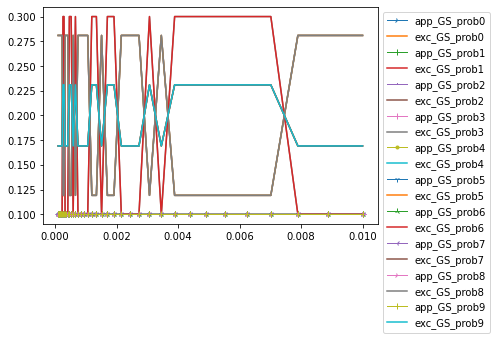

In [199]:
# Compare probabilities

for i in range(len(GS_indices)):
    app_GS_probability_plot = plt.plot(h_x_range, prob_app[i], marker = next(marker), linewidth = 1 , label = 'app_GS_prob' + str(i))
    exc_GS_probability_plot = plt.plot(h_x_range, prob_exc[i], label = 'exc_GS_prob' + str(i))
    plt.legend(loc = 'best', bbox_to_anchor=(1, 1), ncol = 1)

Text(0.5, 0, 'h_x')

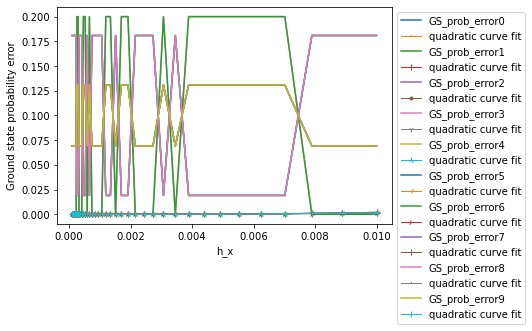

In [200]:
# Calculate and plot probability errors

prob_error_array = np.absolute(prob_app - prob_exc)

# Curve fit
for i in range(len(GS_indices)):
    popt, pcov = optimize.curve_fit(tfim_perturbation.poly_2, h_x_range, prob_error_array[i])
    GS_probability_error_plot = plt.plot(h_x_range, prob_error_array[i], label = 'GS_prob_error' + str(i))
    plt.plot(h_x_range, tfim_perturbation.poly_3(h_x_range, *popt),  marker = next(marker), linewidth = 1, label = 'quadratic curve fit')
    plt.legend(loc = 'best', bbox_to_anchor=(1, 1), ncol = 1)
plt.ylabel('Ground state probability error')
plt.xlabel('h_x')


Text(0.5, 0, 'h_x')

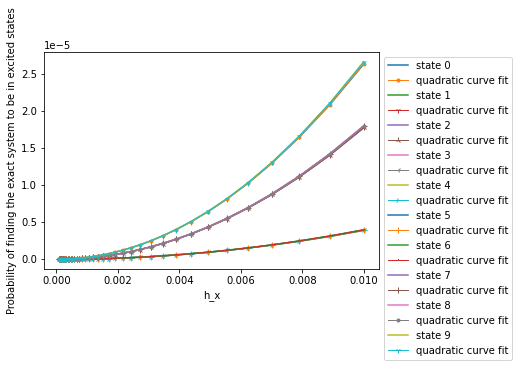

In [201]:
# Probability of finding the exact system to be in excited states
prob_exc_total = tfim_perturbation.prob_exc_total(GS_indices, h_x_range, exc_eigenstates)

prob_excited_sum = tfim_perturbation.prob_excited_sum(GS_indices, h_x_range, prob_exc_total)

for i in range(len(GS_indices)):
    popt, pcov = optimize.curve_fit(tfim_perturbation.poly_2, h_x_range, prob_excited_sum[i])
    plt.plot(h_x_range, prob_excited_sum[i], label = 'state ' + str(i))
    plt.plot(h_x_range, tfim_perturbation.poly_2(h_x_range, *popt), marker = next(marker), linewidth = 1, label = 'quadratic curve fit')
    plt.legend(loc = 'best', bbox_to_anchor=(1, 1), ncol = 1)
plt.ylabel('Probability of finding the exact system to be in excited states')
plt.xlabel('h_x')

In [202]:
# Plot fidelity

# Extract ground states from exc_states matrix and renormalize
normalized_GS_exc_eigenstates = tfim_perturbation.norm_GS_exc_eigenstates(GS_indices, h_x_range, exc_eigenstates)

# Identify energy levels, sort, and calculate fidelity_array to be plotted
GS_exc_eigenvalues = exc_eigenvalues[0:len(GS_indices)]
fidelity_array = tfim_perturbation.fidelity_array(GS_indices, h_x_range, GS_exc_eigenvalues, app_eigenvalues, exc_eigenstates, app_eigenstates)

# Plot fidelity array
for i in range(len(GS_indices)):
    plt.plot(h_x_range, fidelity_array[i], marker = next(marker), linewidth = 1, label = 'state ' + str(i))
    plt.legend(loc = 'best', bbox_to_anchor=(1, 1), ncol = 1)
plt.ylabel('Fidelity between each approximated state and each exact state')
plt.xlabel('h_x')

NameError: name 'app_eigenvalues' is not defined

In [ ]:
# Plot infidelity

infidelity_array = tfim_perturbation.infidelity_array(fidelity_array)

for i in range(len(GS_indices)):
    popt, pcov = optimize.curve_fit(tfim_perturbation.poly_2, h_x_range, infidelity_array[i])
    plt.plot(h_x_range, infidelity_array[i], label = 'state ' + str(i))
    plt.plot(h_x_range, tfim_perturbation.poly_2(h_x_range, *popt), marker = next(marker), linewidth = 1, label = 'quadratic curve fit')
    plt.legend(loc = 'best', bbox_to_anchor=(1, 1), ncol = 1)
plt.ylabel('Infidelity between each approximated state and each exact state')
plt.xlabel('h_x')